# Seam Carving

This colab is to demonstrate [Seam Carving](https://goo.gl/ngnCpb). This is a technique which allows us to re-size images in a content aware manner. This means that we are able remove parts of the image which are less important than others. Clearly, in an image with two people on a beach, one would want to remove parts of the beach rather than the people. The motivation for having such a technique available, according to the original authors, is that dynamically while resizing webpages, images aree handled poorly. This technique allows us to resize images without losing out on quality or content.

We will start off with some imports and installations. All of this stuff is being installed on Google's servers, not your computer. This is nice because it means you don't have to worry about that sort of a thing.

In [ ]:
import numpy as np
import urllib
import io
import shutil
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from matplotlib import pyplot as plt
from PIL import Image
!pip install rpy2
%matplotlib inline

Selecting previously unselected package libxext6:amd64.
(Reading database ... 16669 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.

This little bit of code that I copied and pasted from their documentation lets you upload your own files. Run this cell and click on 'upload file' to choose your own image. It will be loaded into a dictionary with the key as the name of the file you uploaded and the value as the raw content in that file.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "dog.jpg" with length 111344 bytes
User uploaded file "beach.jpg" with length 41858 bytes
User uploaded file "austin.jpg" with length 145428 bytes


The file that I uploaded was calleed `beach.jpg`. You can change that to whatever the name of the file you uploaded was down here. This weird line of code is converting the raw data in the file we uploaded into a 3D array, storing the rows, columns and color channels of the photo that we uploaded.

In [ ]:
file_name = 'beach.jpg'
imagergb = np.array(Image.open(io.BytesIO(bytearray(uploaded[file_name]))))

KeyError: ignored

## The meat of the notebook
It is unusual for jupyter notebooks to have these many functions. However, this project is hard to write without having them, and anotehr nice thing is that it allows us to visualize things well near the end. I highly recommend going straight to the end of these functions down below, seeing what their inputs and outputs look like, and then coming back to see the implementation details.

### Gradients

This first set of two functions get us the gradients in the vertical and horizontal directions respectively. This means that they tell us how much the image is changing in the vertical and horizontal directions. We have visualizations near the end of the notebook..

In [ ]:
def get_grayscale(im):
  # Just a janky function to convert an image to grayscale if it is rgb, else leave it untouched.
  return np.array(Image.fromarray(im).convert('L'), dtype='int32') if len(im.shape) == 3 else np.array(im, dtype=np.float64)

In [ ]:
def gen_vert_energy(im):
  gray_im = get_grayscale(im)
  """Get the energy in the image in the vertical direction.

  This function takes a grayscale image and returns the gradients in the vertical direction.
  """

  # We add a row of zeros at the bottom, because we want the output the same shape as the input.
  buffered_im = np.concatenate((gray_im, np.zeros((1,gray_im.shape[1]), dtype=np.dtype(np.float64))))
  # np.diff returns a 2d array where each value is the same as the difference between itself and the
  # value below. Therefore, the output has one row less.
  return np.abs(np.diff(buffered_im, axis=0))

In [ ]:
def gen_hor_energy(im):
  """Get the energy in the image in the horizontal direction.

  This function takes an rgb image and returns the gradients in the vertical direction.
  """
  # We add a row of zeros to the right, because we want the output the same shape as the input.
  gray_im = get_grayscale(im)
  buffered_im = np.concatenate((gray_im, np.zeros((im.shape[0],1), dtype=np.float64)), axis=1)
  # np.diff returns a 2d array where each value is the same as the difference between itself and the
  # value to the right. Therefore, the output has one column less.
  return np.abs(np.diff(buffered_im, axis=1))

In [ ]:
def get_energy_im(im, horizontal=False):
  """Get the overall energy image.

  This function calculates the gradients in the horizontal direction and the gradients in
  the vertical direction and returns their sum. This is one example of an energy function,
  but many more are possible.
  """
  # Convert image to grayscale if it is not one already.
  gray_im = get_grayscale(im)
  # Return the sum of the energy in the vertical and in the the horizontal image.
  return gen_hor_energy(gray_im) + gen_vert_energy(gray_im)

In [ ]:
def get_vert_cumulative_energy(im, input_energy_im=False):
  """Calculate the cumulative energy in vertical direction.

  This function uses dynamic programming to figure the minimum cost way to get to
  any pixel in the image. This means that the value of a pixel in the result is the
  minimum-cost way of getting there if we are travelling in the vertical direction.

  Args:
    im: Either the energy image or the actual image
    input_energy_im: Tells us whether the input is the energy image or not.
  """
  # get the energy image if the input is just the rgb image/
  energy_im = im.copy() if input_energy_im else get_energy_im(im)
  # What is the number of rows and columns?
  n_rows, n_cols = energy_im.shape
  # Set up our result. We have an extra two columns to pad with infinity. This
  # makes the rest of the code easier to look at.
  result = np.zeros((n_rows, n_cols+2), dtype=np.float64) # dtype is float64 to make sure we have enough precision.
  result[:, 0] = np.inf # Put a column of infinity in the beginning.
  result[:, -1] = np.inf # Same at the end.
  result[0, 1:-1] = energy_im[0,:] # Copy over the first row of the energy image.
  for i in np.arange(1, n_rows):
    for j in np.arange(1,n_cols+1):
      # the pixel in the result is the energy at that pixel plus the minimum cost of the parents.
      result[i][j] = energy_im[i][j-1] + min(result[i-1,j-1:j+2])
  # return the result except the first and the last columns.
  return result[:,1:-1]

In [ ]:
def get_hor_cumulative_energy(im, input_energy_im=False):
  """Calculate the cumulative energy in vertical direction.

  This function uses dynamic programming to figure the minimum cost way to get to
  any pixel in the image. This means that the value of a pixel in the result is the
  minimum-cost way of getting there if we are travelling in the horizontal direction.

  Args:
    im: Either the energy image or the actual image
    input_energy_im: Tells us whether the input is the energy image or not.
  """

  # We are not trying to be efficient C++ coder here. We just transpose the image
  # and get the horizontal cumulative energy.
  energy_im = im if input_energy_im else get_energy_im(im)
  transposed = np.transpose(energy_im, (1,0))
  return np.transpose(get_vert_cumulative_energy(transposed, input_energy_im=True), (1,0))

In [ ]:
def get_seam(im, horizontal=False, original=False):
  """Gets the seam from the cumulative energy image.

  This just looks at the bottom of the image and gets the best pixel, and then
  goes upwards.
  """

  # Were we passed in the original, non-energy image? In that case, we get the energy image first.
  if original:
    if horizontal:
      im = get_hor_cumulative_energy(im)
    else:
      im = get_vert_cumulative_energy(im)

  # We just transpose the image if we want the horizontal seam.
  # It is Python. Keep it simple, stupid.
  if horizontal:
    im = np.transpose(im, (1,0))
  # Set up the seam. The last value is just going to be the minumum value in the
  # last row of the energy image.
  seam = np.zeros(im.shape[0], dtype=np.uint32)
  seam[-1] = np.argmin(im[-1,:])
  # pad the energy image with infinities for the rest of the algorithm, to make
  # the code look nice.
  padded = np.pad(np.float64(im), ((0,0), (1,1)), 'constant', constant_values=np.inf)
  # Go through each row in reverse order, except the last one because we already
  # did what we wanted for that one.
  for i in np.arange(im.shape[0]-2,-1,-1):
    prev = i+1 # We already have the value of the seam for the column/row after us.
    # The colummn/row for this one is the minimum of the parents.
    seam[i] = np.argmin(padded[i][seam[prev]:(seam[prev]+3)]) - 1 + seam[prev]
  return seam

In [ ]:
def highlight_seam(im, seam, horizontal=False):
  """Highlight the seam in the input image.

  This function takes an image and a seam and colors all the pixels which belong
  to a seam red.
  """
  new_im = im.copy()
  red = [255,0,0]
  if horizontal:
    for i, seam_row in enumerate(seam):
      new_im[seam_row][i] = red
  else:
    for i, seam_col in enumerate(seam):
      new_im[i][seam_col] = red
  return new_im

In [ ]:
def remove_seam(im, seam, horizontal=False):
  """Remove the seam from the input image.
  """
  new_im = im.transpose((1,0,2)) if horizontal else im.copy()
  old_rows, old_cols, old_cc = new_im.shape
  smaller_im = np.zeros((old_rows, old_cols-1, old_cc), dtype=np.dtype(np.uint8))
  for row, col in enumerate(seam):
    smaller_im[row,:] = np.concatenate((new_im[row,0:col,:], new_im[row,col+1:,:]))
  return smaller_im.transpose((1,0,2)) if horizontal else smaller_im

### Start reading from here.
If you looked at my note above, this is where you should start reading from in this notebook. Let's go through the functions above and see what they do. We will start of by looking at the our image.

(-0.5, 506.5, 337.5, -0.5)

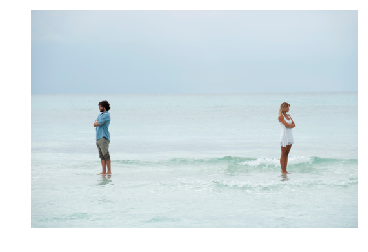

In [ ]:
plt.imshow(imagergb)
plt.axis('off')

So that is an image of two people on the beach. I don't like the fact that they are so far apart. They deserve to be closer together. So, what happens if we just squeese them together?

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(-0.5, 100.5, 337.5, -0.5)

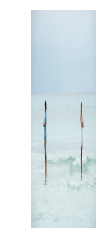

In [ ]:
from scipy.misc import imresize
n_rows, n_cols, n_cc = imagergb.shape
im_resized = imresize(imagergb, (n_rows,int(n_cols/5)))
plt.imshow(im_resized)
plt.axis('off')

That looks terrible. What if we tried to  remove the middle part?

In [ ]:
im_first_part = np.concatenate((imagergb[:,:170], imagergb[:,301:]), axis=1)

(-0.5, 375.5, 337.5, -0.5)

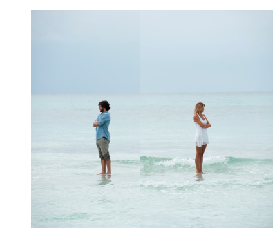

In [ ]:
plt.imshow(im_first_part)
plt.axis('off')

That was better, bbut you can tell really clearly where we did the cutting and pasting. So, now we will try the seam carving way of doing it instead

(-0.5, 376.5, 337.5, -0.5)

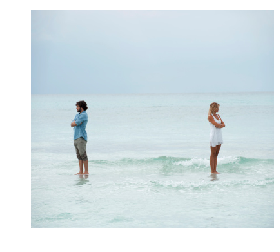

In [ ]:
num_columns_to_remove = 130
imcopy = imagergb.copy()
for i in np.arange(num_columns_to_remove):
  cumulative_energy = get_vert_cumulative_energy(imcopy)
  seam = get_seam(cumulative_energy)
  imcopy = remove_seam(imcopy, seam)

plt.imshow(imcopy)
plt.axis('off')

Much better. The story is complete. Now let's see how this whole process worked. First, we will look at the gradients.

(-0.5, 506.5, 337.5, -0.5)

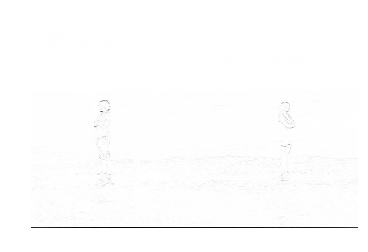

In [ ]:
vert_gradients = gen_vert_energy(imagergb)
plt.imshow(vert_gradients)
plt.axis('off')

We see clear outlines at the edges of our two subjects. That is what we expected. Now, let us see what the horizontal gradients look like.

(-0.5, 506.5, 337.5, -0.5)

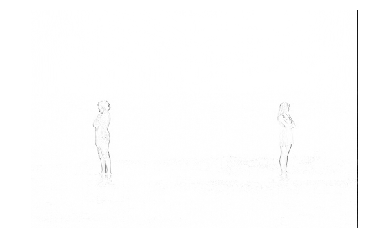

In [ ]:
hor_gradients = gen_hor_energy(imagergb)
plt.imshow(hor_gradients)
plt.axis('off')

As we can see, a lot of the waves disappeared. This is because those are vertical gradietns, not horizontal. The values of the pixels are changing in the vertical direction for the waves, not in the hroizontal directions. Now let's see what happens when we add these together. That is what is happening in `get_energy_im`.

(-0.5, 506.5, 337.5, -0.5)

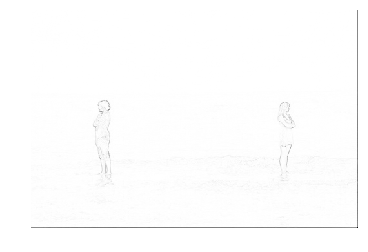

In [ ]:
energy_im = get_energy_im(imagergb)
plt.imshow(energy_im)
plt.axis('off')

Good stuff. Now let's look at what the cumulative energy image looks like. Remember that this shows you the minimum cost way of getting to each pixel.

(-0.5, 506.5, 337.5, -0.5)

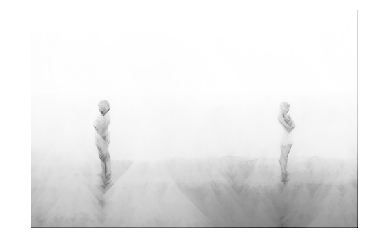

In [ ]:
vert_cumulative_energy_image = get_vert_cumulative_energy(imagergb)
plt.imshow(vert_cumulative_energy_image)
plt.axis('off')

Somethign interesting is happening here. If you look closely, the image gets darker right above the people's heads. That is because there is a vertical gradient there as the sky meets the ground. also, there is a lot of energy around the people, because of the large amount of energy there. Clearly, we want to avoid the people, so that's good to see. Let's look at the horizontal cumulative energy image as well.

(-0.5, 506.5, 337.5, -0.5)

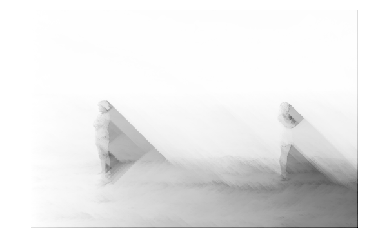

In [ ]:
hor_cumulative_energy_image = get_hor_cumulative_energy(imagergb)
plt.imshow(hor_cumulative_energy_image)
plt.axis('off')

Cool, that is exactly what we are looking for. Now, let us get the seam and see what happens.

(-0.5, 506.5, 337.5, -0.5)

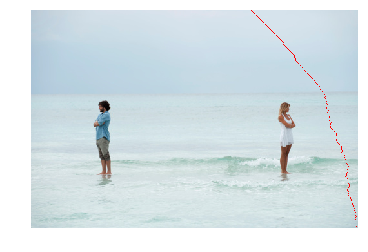

In [ ]:
seam = get_seam(imagergb, original=True)
highlighted = highlight_seam(imagergb, seam)
plt.imshow(highlighted)
plt.axis('off')

That seam to the far right makes a lot of sense. It is not intersecting any of ht ehumans, and it is also avoiding that large wave. We are going to call this good. Let us look at a couple of other quick examples.

(-0.5, 599.5, 321.5, -0.5)

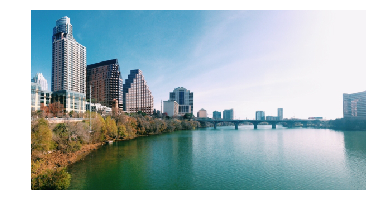

In [ ]:
file_name = 'austin.jpg'
austin = np.array(Image.open(io.BytesIO(bytearray(uploaded[file_name]))))
# Show the image
plt.imshow(austin)
plt.axis('off')

(-0.5, 599.5, 321.5, -0.5)

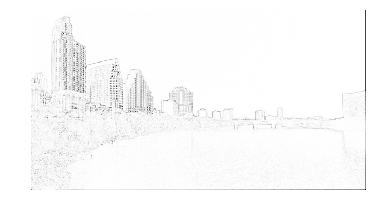

In [ ]:
# Show the gradient
austin_grad = get_energy_im(austin)
plt.imshow(austin_grad)
plt.axis('off')

(-0.5, 599.5, 321.5, -0.5)

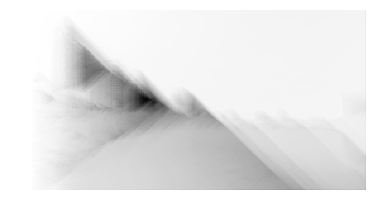

In [ ]:
# Show the cumulative energy
austin_cumulative = get_hor_cumulative_energy(austin)
plt.imshow(austin_cumulative)
plt.axis('off')

(-0.5, 599.5, 321.5, -0.5)

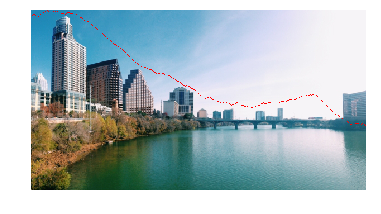

In [ ]:
# Whot the seam
seam = get_seam(austin, horizontal=True, original=True)
highlight = highlight_seam(austin, seam, horizontal=True)
plt.imshow(highlight)
plt.axis('off')

(-0.5, 599.5, 246.5, -0.5)

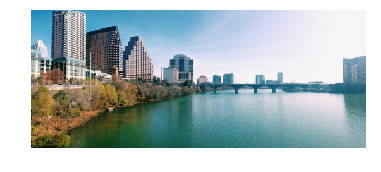

In [ ]:
num_rows_to_remove = 75
imcopy = austin.copy()
for i in np.arange(num_rows_to_remove):
  cumulative_energy = get_hor_cumulative_energy(imcopy)
  seam = get_seam(cumulative_energy, horizontal=True)
  imcopy = remove_seam(imcopy, seam, horizontal=True)
plt.imshow(imcopy)
plt.axis('off')

Look at how the slope of the shoreline has changed, and how most of the sky is gone. Prettyyyyy cool.
